# Compare Top Feature Performance with k = 200

**Gregory Way, 2019**

Here, I compare the results of aggregating the top 200 features for each algorithm (and the top 200 features for all algorithms combined) with the models originally trained using k = 200.

I also compare results using the top 1 feature for all algorithms and 200 randomized features from all algorithms.

In [1]:
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "viz_util.R"))

In [2]:
genes <- c("TP53", "PTEN", "PIK3CA", "KRAS", "TTN")

In [3]:
# Load all mutation classification results
mut_path <- file.path("results", "top_feature_classification")
top_feature_df <- load_results(results_path = mut_path,
                               process_output = FALSE, 
                               uses_top_features = TRUE)
top_feature_df <- top_feature_df[['metrics']]
top_feature_df <- top_feature_df %>% dplyr::filter(data_type == 'cv')
top_feature_df$gene_or_cancertype <- factor(top_feature_df$gene_or_cancertype, levels = genes)

print(dim(top_feature_df))

head(top_feature_df, 2)

[1] 90  8


auroc,aupr,gene_or_cancertype,signal,z_dim,seed,algorithm,data_type
0.69693,0.37731,KRAS,real,top_features: 1,any,PCA,cv
0.76009,0.52020,KRAS,real,top_features: 200,any,PCA,cv


In [4]:
# Load all mutation classification results
mut_path <- file.path("results", "mutation")

full_mutation_df <- load_results(results_path = mut_path, process_output = FALSE)

full_mutation_raw_df <- full_mutation_df[['raw_metrics']]
full_mutation_df <- full_mutation_df[['metrics']]

In [5]:
# Process mutation results
full_mutation_df <- full_mutation_df %>%
    dplyr::filter(z_dim == 200,
                  gene_or_cancertype %in% genes,
                  data_type == 'cv')
full_mutation_raw_df <- full_mutation_raw_df %>%
    dplyr::filter(gene_or_cancertype %in% genes,
                  data_type == 'cv')

full_mutation_df$gene_or_cancertype <- factor(full_mutation_df$gene_or_cancertype, levels = genes)
full_mutation_df$signal <- factor(full_mutation_df$signal, levels = c("signal", "shuffled"))
full_mutation_raw_df$gene_or_cancertype <- factor(full_mutation_raw_df$gene_or_cancertype, levels = genes)
full_mutation_raw_df$signal <- factor(full_mutation_raw_df$signal, levels = c("signal", "shuffled"))

full_mutation_df <- full_mutation_df %>%
    dplyr::group_by(algorithm,
                    data_type,
                    gene_or_cancertype,
                    algorithm,
                    signal,
                    z_dim) %>% 
    summarise(mean_auroc = mean(auroc),
              mean_aupr = mean(aupr))

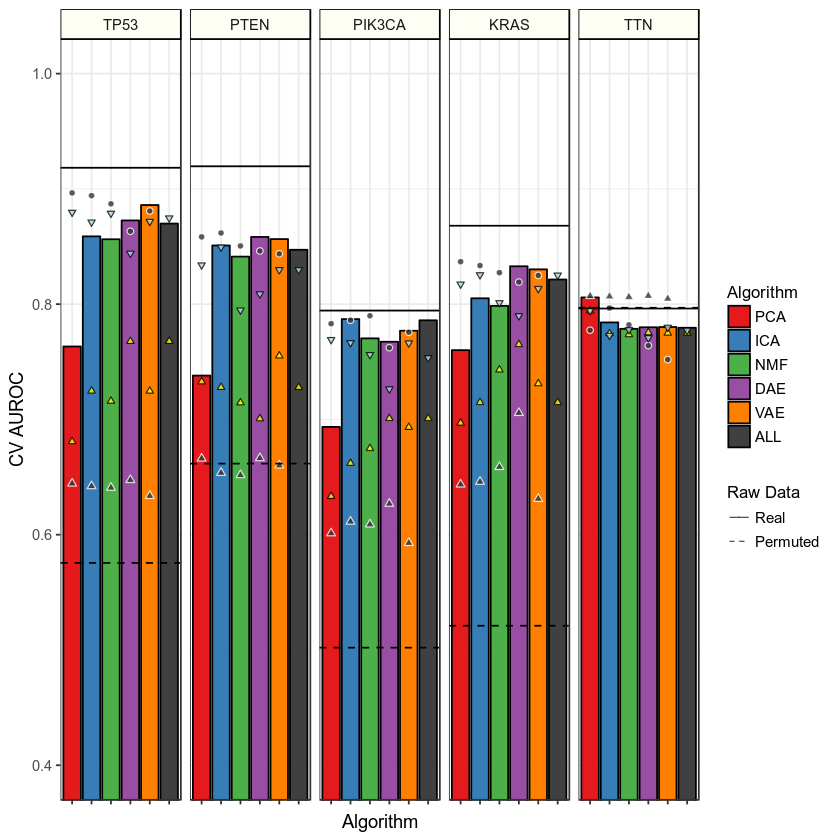

In [6]:
source(file.path("scripts", "viz_util.R"))
panel_a_auroc <- plot_top_features(top_feature_df,
                                   full_mutation_df,
                                   full_mutation_raw_df,
                                   auroc_or_aupr = 'AUROC')
panel_a_auroc

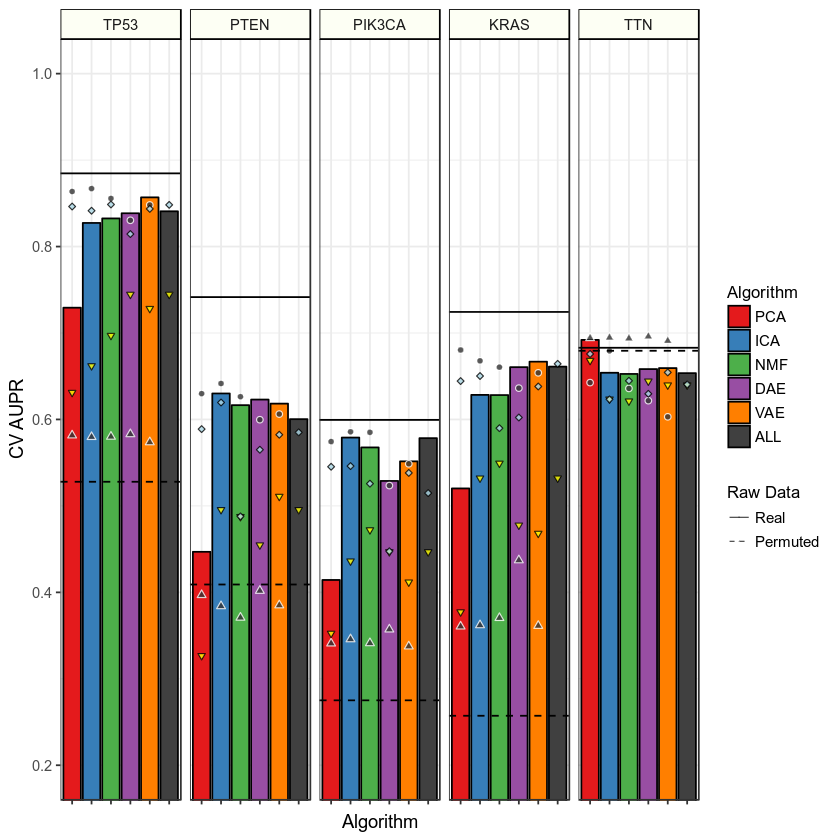

In [7]:
panel_b_aupr <- plot_top_features(top_feature_df,
                                  full_mutation_df,
                                  full_mutation_raw_df,
                                  auroc_or_aupr = 'AUPR')

panel_b_aupr

In [8]:
# Now, build a custom figure legend

In [9]:
custom_data <- as.data.frame(cbind(c(1, 3, 5, 7), c(5, 3, 6, 7), c("A", "B", "C", "D")))
colnames(custom_data) <- c('one', 'two', 'three')
custom_data

one,two,three
1,5,A
3,3,B
5,6,C
7,7,D


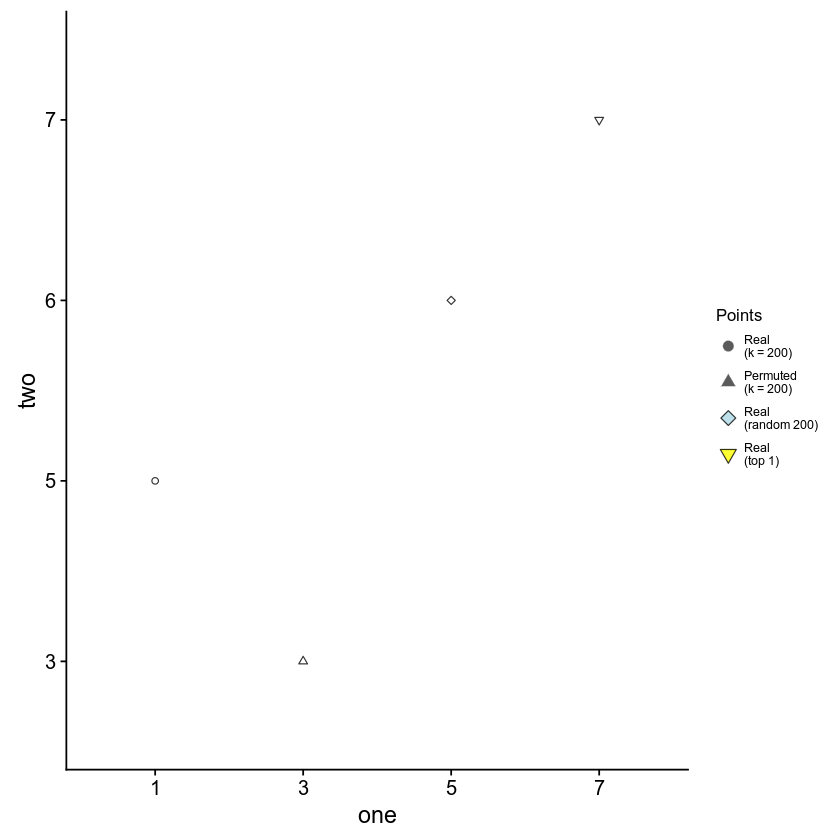

In [10]:
custom_gg <- ggplot(custom_data,
                    aes(x = one, y = two)) +
    geom_point(aes(shape = three),
               alpha = 0.8) +
    scale_shape_manual(name = "Points",
                       values = c(21, 24, 23, 25),
                       labels = c("Real\n(k = 200)", "Permuted\n(k = 200)",
                                  "Real\n(random 200)",
                                  "Real\n(top 1)")) +
    guides(shape = guide_legend(override.aes = list(fill = c("grey20",
                                                             "grey20",
                                                             "lightblue",
                                                             "yellow"),
                                                    color = c("white",
                                                              "white",
                                                              "black",
                                                              "black"),
                                                    size = 3),
                                keywidth = 1,
                                keyheight = 1.5,
                                default.unity = "mm")) +
    theme(legend.position = "right",
          legend.title = element_text(size = 10),
          legend.text = element_text(size = 7.5),
          legend.key.size = unit(1, "lines"))

custom_gg

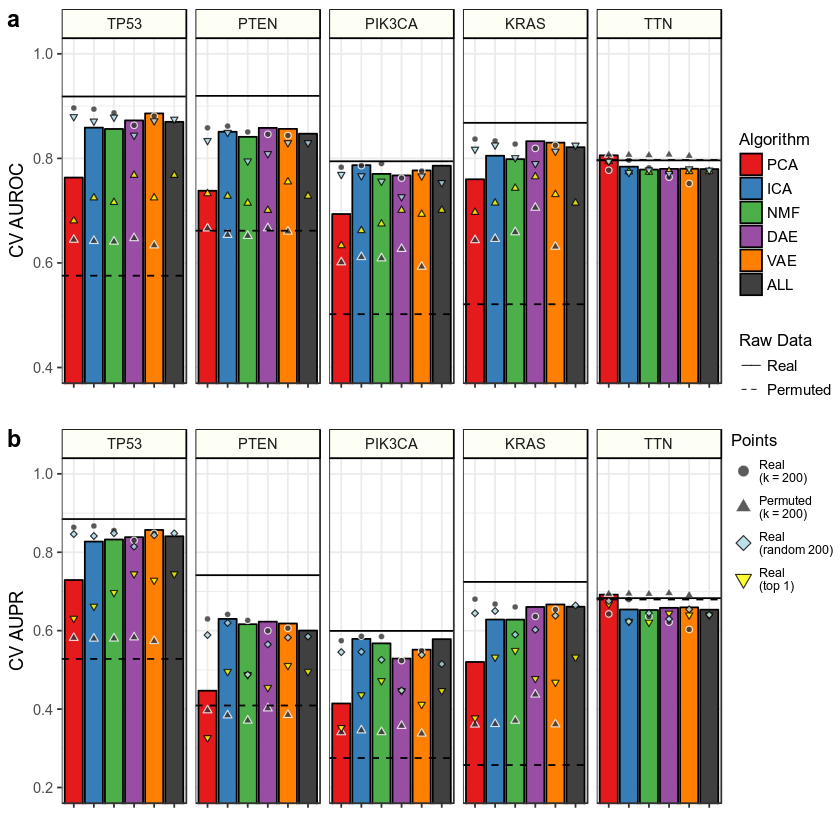

In [11]:
# Create multipanel plot
alg_legend <- cowplot::get_legend(panel_b_aupr)
custom_legend <- cowplot::get_legend(custom_gg)

main_plot <- (
    cowplot::plot_grid(
        panel_a_auroc + theme(legend.position = 'none') + xlab(""),
        panel_b_aupr + theme(legend.position = "none") + xlab(""),
        labels = c("a", "b"),
        ncol = 1,
        nrow = 2
    )
)

full_legend <- (
    cowplot::plot_grid(
        ggdraw(),
        alg_legend,
        custom_legend,
        ggdraw(),
        ncol = 1,
        nrow = 4,
        rel_heights = c(0.9, 1, 1.6, 0.9)
    )
)

main_plot = cowplot::plot_grid(main_plot,
                               full_legend,
                               rel_widths = c(1, 0.15),
                               ncol = 2)
main_plot

In [12]:
for(extension in c('.png', '.pdf')) {
    sup_file <- paste0("supplemental_tcga_top_feature_summary", extension)
    sup_file <- file.path("figures", sup_file)
    cowplot::save_plot(filename = sup_file,
                       plot = main_plot,
                       base_height = 6,
                       base_width = 7)
}